In [1]:
import gc
import time
import argparse
from fastai.layers import swish

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

from fastai.callback.schedule import Learner
from fastai.data.core import DataLoaders
from fastai.losses import L1LossFlat
from fastai.callback.core import Callback
from fastai.callback.tracker import ReduceLROnPlateau, SaveModelCallback

from HW_torch import dataLoads_build, net_parameter_count, hw_layer
from HW_base import evaluate_build, focus_build

In [18]:
fname               = 'F25_LSTM128x4-FC-SELU-FC'
epoch_num_first     = 100
batch_size_first    = 100
epoch_num_second    = 200
batch_size_second   = 1000
evaluate_num        = 128
focus_min           = 0.6

In [3]:
class net_test(torch.nn.Module):
    def __init__(self, **kwargs):
        super(net_test, self).__init__()
        self.lstm = torch.nn.LSTM(25, 128, num_layers=4, bias=False, bidirectional=True, batch_first=True)
        self.fc1 = torch.nn.Linear(128*2, 32, bias=False)
        self.selu = nn.SELU()
        self.fc2 = torch.nn.Linear(32, 1, bias=True)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc1(x)
        x = self.selu(x)
        x = self.fc2(x)
        return x

In [4]:
data_train_df = pd.read_csv('./Database/train.csv')
data_test_df = pd.read_csv('./Database/test.csv')

In [5]:
def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    #df['u_in_lag'] = df['u_in'].shift(2).fillna(0)
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R']+df['C']
    df = pd.get_dummies(df)
    return df

data_train_df = add_features(data_train_df)
data_test_df = add_features(data_test_df)

In [6]:
drop_columns = ['pressure','id', 'breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2']
x_columns = [col for col in data_train_df.columns if col not in drop_columns]
y_columns = ['pressure']

In [7]:
RS = RobustScaler()
data_train = data_train_df[x_columns].values.astype(np.float32)
data_train = RS.fit_transform(data_train)
data_train = data_train.reshape(-1, 80, data_train.shape[-1])

target_train = data_train_df[y_columns].values.astype(np.float32)
target_train = target_train. reshape(-1, 80, target_train.shape[-1])

data_test = data_test_df[x_columns].values.astype(np.float32)
data_test = RS.transform(data_test)
data_test = data_test.reshape(-1, 80, data_test.shape[-1])

In [8]:
np.random.seed(121212)
data_idx = np.arange(len(data_train))
np.random.shuffle(data_idx)

train_index = data_idx[:int(len(data_idx)*0.8)]
valid_index = data_idx[int(len(data_idx)*0.8):]

In [9]:
x_train, y_train = data_train[train_index], target_train[train_index]
x_valid, y_valid = data_train[valid_index], target_train[valid_index]
x_test = data_test

In [10]:
del data_train_df
del data_test_df
gc.collect()

0

In [11]:
model = net_test()
print(model)

train_parameter_num, freeze_parameter_num = net_parameter_count(model)
print(train_parameter_num, freeze_parameter_num)

net_test(
  (lstm): LSTM(25, 128, num_layers=4, bias=False, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=32, bias=False)
  (selu): SELU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)
1344545 0


epoch,train_loss,valid_loss,time
0,1.581051,1.384942,00:27
1,1.037034,1.029333,00:26
2,0.934582,0.918573,00:26
3,0.820898,0.772266,00:26
4,0.735051,0.725914,00:26
5,0.714208,0.713494,00:26
6,0.674808,0.636142,00:26
7,0.645759,0.741548,00:26
8,0.609829,0.589049,00:26
9,0.588470,0.628006,00:26


Epoch 13: reducing lr to 0.00012196898856054322
Epoch 23: reducing lr to 0.00019924050533362274
Epoch 33: reducing lr to 0.0001929802728266057
Epoch 45: reducing lr to 0.0001637481066780984
Epoch 55: reducing lr to 0.00012689939722819655
Epoch 65: reducing lr to 8.53996925551048e-05
Epoch 75: reducing lr to 4.6424720137298285e-05
Epoch 85: reducing lr to 1.6713543256929863e-05
Epoch 95: reducing lr to 1.4035384095275466e-06


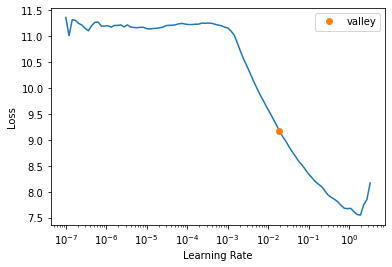

In [12]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_first)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_first, lr_max=2e-3, cbs=ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10))

epoch,train_loss,valid_loss,time
0,0.135634,0.171740,00:14
1,0.135508,0.171632,00:15
2,0.135303,0.171799,00:14
3,0.135398,0.171681,00:14
4,0.134986,0.171778,00:14
5,0.135051,0.171800,00:14
6,0.135069,0.171772,00:14
7,0.135450,0.171842,00:14
8,0.135566,0.171872,00:15
9,0.135591,0.171731,00:14


Better model found at epoch 0 with valid_loss value: 0.17173972725868225.
Better model found at epoch 1 with valid_loss value: 0.1716318130493164.
Epoch 10: reducing lr to 2.9967737103779228e-05
Epoch 20: reducing lr to 8.003000730042371e-05
Epoch 30: reducing lr to 0.00013924799608184903
Epoch 40: reducing lr to 0.00018500244994715736
Epoch 50: reducing lr to 0.00019997878165973243
Epoch 60: reducing lr to 0.00019736575212051785
Epoch 70: reducing lr to 0.0001904974131120252
Epoch 80: reducing lr to 0.0001796739458424247
Epoch 90: reducing lr to 0.00016536839801694806
Epoch 100: reducing lr to 0.00014820596770888172
Better model found at epoch 109 with valid_loss value: 0.1713421791791916.
Epoch 110: reducing lr to 0.00012893674737234285
Better model found at epoch 116 with valid_loss value: 0.17131498456001282.
Better model found at epoch 117 with valid_loss value: 0.17103378474712372.
Epoch 120: reducing lr to 0.00010840292303861373
Better model found at epoch 123 with valid_loss va

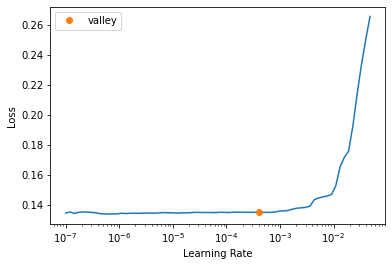

In [13]:
dataLoads = dataLoads_build(x_train, y_train, x_valid, y_valid, batch_size_second)
learn = Learner(dataLoads, model, loss_func=L1LossFlat())
learn.lr_find()
learn.fit_one_cycle(epoch_num_second, lr_max=2e-3, cbs=[ReduceLROnPlateau(monitor='valid_loss', min_delta=0.5, patience=10),
                                                        SaveModelCallback(monitor='valid_loss', fname=f'{fname}_best')])

In [14]:
from HW_torch import torch_valid, torch_predict

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

state_dict = torch.load(f'models/{fname}_best.pth')
model.load_state_dict(state_dict)

loss = torch_valid([model.to(device)], L1LossFlat(), (x_train, y_train),  batch_size_second, to_device=device)
valid_loss = torch_valid([model.to(device)], L1LossFlat(), (x_valid, y_valid),  batch_size_second, to_device=device)

print(loss, valid_loss)

0.10747050335172748 0.1683060172945261


In [15]:
predict = torch_predict([model.to(device)], x_test, batch_size_second, to_device=device)
predict = np.reshape(predict, (-1))

prodict: 100% 51/51 [00:03<00:00, 16.35it/s]


In [19]:
df = pd.read_csv('Database/sample_submission.csv', index_col=0)
df['pressure'] = predict

df.to_csv(f'Submission/{fname}.csv')